In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt



In [32]:
# Paso 1: Cargar los datos
# URL del dataset en GitHub
url = "https://raw.githubusercontent.com/kjra99/AMR_TFM/refs/heads/main/kidney_disease.csv"
# Cargar los datos directamente desde GitHub
data = pd.read_csv(url)

# Verificar la carga correcta mostrando las primeras filas
data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [33]:
# Renombrar columnas para mayor claridad
data.rename(columns={
    'id': 'ID',
    'age': 'Edad',
    'bp': 'Presion_Arterial',
    'sg': 'Gravedad_Especifica',
    'al': 'Albumina',
    'su': 'Azucar',
    'rbc': 'Globulos_Rojos',
    'pc': 'Celulas_Epiteliales',
    'pcc': 'Celulas_Cumulos',
    'ba': 'Bacterias',
    'bgr': 'Glucosa_Sangre',
    'bu': 'Urea_Sangre',
    'sc': 'Creatinina_Sangre',
    'sod': 'Sodio',
    'pot': 'Potasio',
    'hemo': 'Hemoglobina',
    'pcv': 'Volumen_Celular',
    'wc': 'Globulos_Blancos',
    'rc': 'Recuento_Rojos',
    'htn': 'Hipertension',
    'dm': 'Diabetes',
    'cad': 'Cardiopatia',
    'appet': 'Apetito',
    'pe': 'Edema_Pedal',
    'ane': 'Anemia',
    'classification': 'Clasificacion'
}, inplace=True)

import numpy as np

# Agregar una columna de Sexo con valores aleatorios
np.random.seed(42)  # Para reproducibilidad
data['Sexo'] = np.random.choice(['F', 'M'], size=len(data), p=[0.5, 0.5])




In [34]:
# Paso 2: Filtrar pacientes con ERC
data = data[data['Clasificacion'] == 'ckd']

# Paso 3: Preprocesamiento
# Eliminar filas con valores nulos en la columna 'Diabetes'
data = data.dropna(subset=['Diabetes'])



In [35]:
# Selección de variables relevantes
variables = ['Edad', 'Presion_Arterial', 'Glucosa_Sangre', 'Urea_Sangre','Azucar', 'Sodio',
             'Creatinina_Sangre', 'Potasio', 'Hemoglobina', 'Albumina']


# Imputación de valores nulos
for col in variables:
    if data[col].isnull().sum() > 0:
        if data[col].dtype == 'object':
            data[col].fillna(data[col].mode()[0], inplace=True)
        else:
            data[col].fillna(data[col].mean(), inplace=True)

# Convertir columnas categóricas a numéricas
binary_columns = ['Hipertension', 'Diabetes', 'Cardiopatia', 'Edema_Pedal', 'Anemia']
for col in binary_columns:
    data[col] = data[col].map({'yes': 1, 'no': 0})

categorical_columns = {
    'Globulos_Rojos': {'normal': 0, 'abnormal': 1},
    'Celulas_Epiteliales': {'normal': 0, 'abnormal': 1},
    'Apetito': {'good': 1, 'poor': 0},
    'Celulas_Cumulos': {'notpresent': 0, 'present': 1},
    'Bacterias': {'notpresent': 0, 'present': 1}
}

for col, mapping in categorical_columns.items():
    data[col] = data[col].map(mapping)

<ipython-input-35-c46f95d1c2dd>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)


In [59]:
# Paso 1: Rellenar o eliminar valores nulos en 'Diabetes'
data['Diabetes'] = data['Diabetes'].fillna(data['Diabetes'].mode()[0])  # Rellenar con la moda

# Verificar que no haya valores nulos en 'Diabetes'
print("Valores únicos en 'Diabetes' después de la limpieza:", data['Diabetes'].unique())




Valores únicos en 'Diabetes' después de la limpieza: [1. 0.]


In [60]:
data.describe()

,ID,Edad,Presion_Arterial,Gravedad_Especifica,Albumina,Azucar,Globulos_Rojos,Celulas_Epiteliales,Celulas_Cumulos,Bacterias,...,Sodio,Potasio,Hemoglobina,Hipertension,Diabetes,Cardiopatia,Apetito,Edema_Pedal,Anemia,TFG
count,248.000000,2.480000e+02,2.480000e+02,207.000000,2.480000e+02,2.480000e+02,106.000000,193.000000,248.000000,248.000000,...,2.480000e+02,2.480000e+02,2.480000e+02,248.000000,248.000000,246.000000,248.000000,248.000000,248.000000,248.000000
mean,124.427419,1.683241e-16,1.647428e-16,1.013937,-2.542769e-16,7.162729e-18,0.443396,0.388601,0.165323,0.088710,...,-2.256260e-16,1.217664e-16,1.504173e-16,0.584677,0.556452,0.138211,0.677419,0.306452,0.237903,34.243996
std,72.079429,1.002022e+00,1.002022e+00,0.004630,1.002022e+00,1.002022e+00,0.499146,0.488700,0.372223,0.284899,...,1.002022e+00,1.002022e+00,1.002022e+00,0.493774,0.497808,0.345825,0.468409,0.461952,0.426661,33.111300
min,0.000000,-3.067123e+00,-1.993305e+00,1.005000,-1.369299e+00,-6.291101e-01,0.000000,0.000000,0.000000,0.000000,...,-1.272853e+01,-6.740431e-01,-3.820726e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.325643
25%,62.750000,-3.905206e-01,-6.512777e-01,1.010000,-5.737288e-01,-6.291101e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,-2.214811e-01,-4.311432e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.498225
50%,124.500000,2.384077e-01,1.973569e-02,1.015000,-1.766522e-16,-6.291101e-01,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,2.512224e-16,-8.986730e-16,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,24.450740
75%,186.250000,6.186900e-01,6.907491e-01,1.015000,1.017412e+00,0.000000e+00,1.000000,1.000000,0.000000,0.000000,...,3.066938e-01,2.512224e-16,5.806726e-01,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,43.800321
max,249.000000,2.081314e+00,6.729870e+00,1.025000,2.608553e+00,3.452142e+00,1.000000,1.000000,1.000000,1.000000,...,2.864550e+00,1.191284e+01,2.756077e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,161.953230


In [61]:
print(data.columns)


Index(['ID', 'Edad', 'Presion_Arterial', 'Gravedad_Especifica', 'Albumina',
       'Azucar', 'Globulos_Rojos', 'Celulas_Epiteliales', 'Celulas_Cumulos',
       'Bacterias', 'Glucosa_Sangre', 'Urea_Sangre', 'Creatinina_Sangre',
       'Sodio', 'Potasio', 'Hemoglobina', 'Volumen_Celular',
       'Globulos_Blancos', 'Recuento_Rojos', 'Hipertension', 'Diabetes',
       'Cardiopatia', 'Apetito', 'Edema_Pedal', 'Anemia', 'Clasificacion',
       'Sexo', 'TFG', 'Estadio_ERC'],
      dtype='object')


In [62]:
data[variables].describe()

,Edad,Presion_Arterial,Glucosa_Sangre,Urea_Sangre,Azucar,Sodio,Creatinina_Sangre,Potasio,Hemoglobina,Albumina
count,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02
mean,1.683241e-16,1.647428e-16,7.520866e-17,-2.148819e-17,7.162729e-18,-2.256260e-16,-7.162729e-17,1.217664e-16,1.504173e-16,-2.542769e-16
std,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00
min,-3.067123e+00,-1.993305e+00,-1.808412e+00,-1.247448e+00,-6.291101e-01,-1.272853e+01,-5.787384e-01,-6.740431e-01,-3.820726e+00,-1.369299e+00
25%,-3.905206e-01,-6.512777e-01,-7.629941e-01,-7.127487e-01,-6.291101e-01,0.000000e+00,-4.315037e-01,-2.214811e-01,-4.311432e-01,-5.737288e-01
50%,2.384077e-01,1.973569e-02,-1.239637e-01,-3.095327e-01,-6.291101e-01,0.000000e+00,-2.916308e-01,2.512224e-16,-8.986730e-16,-1.766522e-16
75%,6.186900e-01,6.907491e-01,4.149420e-01,3.040570e-01,0.000000e+00,3.066938e-01,0.000000e+00,2.512224e-16,5.806726e-01,1.017412e+00
max,2.081314e+00,6.729870e+00,3.704328e+00,5.580928e+00,3.452142e+00,2.864550e+00,1.053748e+01,1.191284e+01,2.756077e+00,2.608553e+00


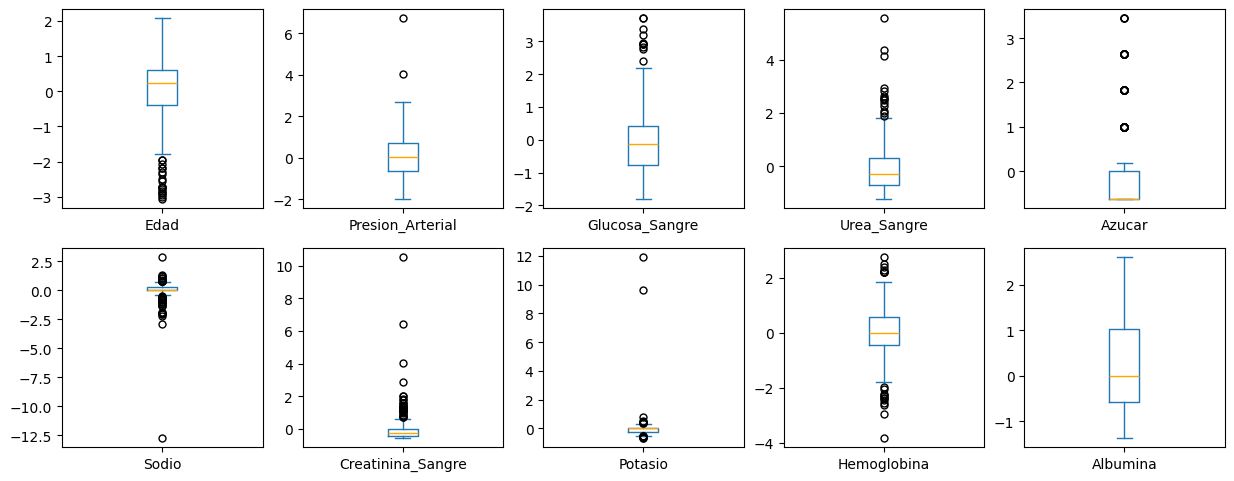

In [63]:
import matplotlib.pyplot as plt

# Supongamos que data es tu DataFrame

# Crear gráficos de caja para cada columna
data[variables].plot(kind='box', subplots=True, layout=(5, 5), figsize=(15, 15), boxprops=dict(color='#1f77b4'), capprops=dict(color='#1f77b4'), whiskerprops=dict(color='#1f77b4'), medianprops=dict(color='orange'), flierprops=dict(marker='o', color='black', markersize=5, markeredgecolor='black'))

# Mostrar el gráfico
plt.show()

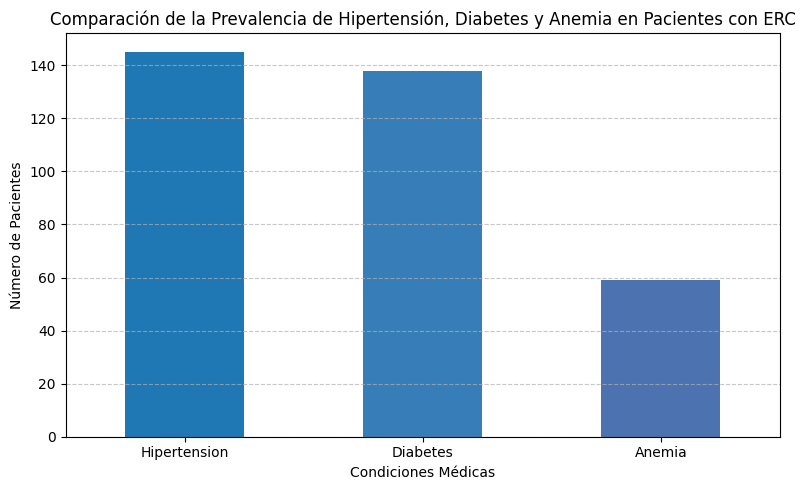

     Hipertension  Diabetes  Anemia
0               1       1.0       0
1               0       0.0       0
2               0       1.0       1
3               1       0.0       1
4               0       0.0       0
..            ...       ...     ...
245             1       0.0       0
246             1       0.0       1
247             0       0.0       1
248             1       1.0       0
249             1       1.0       1

[248 rows x 3 columns]


In [64]:
import matplotlib.pyplot as plt

# Seleccionar las columnas de interés para la comparación
conditions = ['Hipertension', 'Diabetes', 'Anemia']

# Contar la cantidad de pacientes con cada condición
condition_counts = data[conditions].sum()

# Crear el gráfico de barras
plt.figure(figsize=(8, 5))
condition_counts.plot(kind='bar', color=['#1f77b4', '#377eb8', '#4c72b0'])  # Tonos de azul


# Personalizar el gráfico
plt.title('Comparación de la Prevalencia de Hipertensión, Diabetes y Anemia en Pacientes con ERC')
plt.ylabel('Número de Pacientes')
plt.xlabel('Condiciones Médicas')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

print(data[conditions])

In [42]:
import pandas as pd
import numpy as np


# Paso 2: Calcular la TFG usando la fórmula CKD-EPI
def calcular_tfg(row):
    # Parámetros de la fórmula
    kappa = 0.7 if row['Sexo'] == 'F' else 0.9
    alfa = -0.329 if row['Sexo'] == 'F' else -0.411
    factor_sexo = 1.018 if row['Sexo'] == 'F' else 1
    factor_raza = 1  # Asumimos factor de raza de 1

    # Creatinina sérica
    cr = row['Creatinina_Sangre']

    # Verificar que la creatinina no sea nula
    if pd.isna(cr):
        return np.nan  # Devolver NaN si la creatinina no está disponible

    # Fórmula CKD-EPI
    tfg = (141 * min(cr / kappa, 1) ** alfa *
           max(cr / kappa, 1) ** -1.209 *
           (0.993 ** row['Edad']) *
           factor_sexo * factor_raza)
    return tfg

# Asegurar que no haya valores nulos en Edad o Creatinina_Sangre antes de aplicar
data['Edad'] = data['Edad'].fillna(data['Edad'].mean())
data['Creatinina_Sangre'] = data['Creatinina_Sangre'].fillna(data['Creatinina_Sangre'].mean())

# Agregar la columna de TFG
data['TFG'] = data.apply(calcular_tfg, axis=1)

# Verificar los resultados
print(data[['Edad', 'Sexo', 'Creatinina_Sangre', 'TFG']].head())

   Edad Sexo  Creatinina_Sangre         TFG
0  48.0    F                1.2   53.397905
1   7.0    M                0.8  140.892391
2  62.0    M                1.8   39.457290
3  48.0    M                3.8   17.640215
4  51.0    F                1.4   43.394361


In [43]:
# Función para clasificar el estadio según la TFG
def clasificar_estadio(tfg):
    if pd.isna(tfg):
        return np.nan
    elif tfg >= 90:
        return 'Estadio 1'
    elif 60 <= tfg < 90:
        return 'Estadio 2'
    elif 45 <= tfg < 60:
        return 'Estadio 3a'
    elif 30 <= tfg < 45:
        return 'Estadio 3b'
    elif 15 <= tfg < 30:
        return 'Estadio 4'
    else:
        return 'Estadio 5'

# Aplicar la clasificación al DataFrame
data['Estadio_ERC'] = data['TFG'].apply(clasificar_estadio)

# Verificar los resultados
print(data[['TFG', 'Estadio_ERC']].head())

          TFG Estadio_ERC
0   53.397905  Estadio 3a
1  140.892391   Estadio 1
2   39.457290  Estadio 3b
3   17.640215   Estadio 4
4   43.394361  Estadio 3b


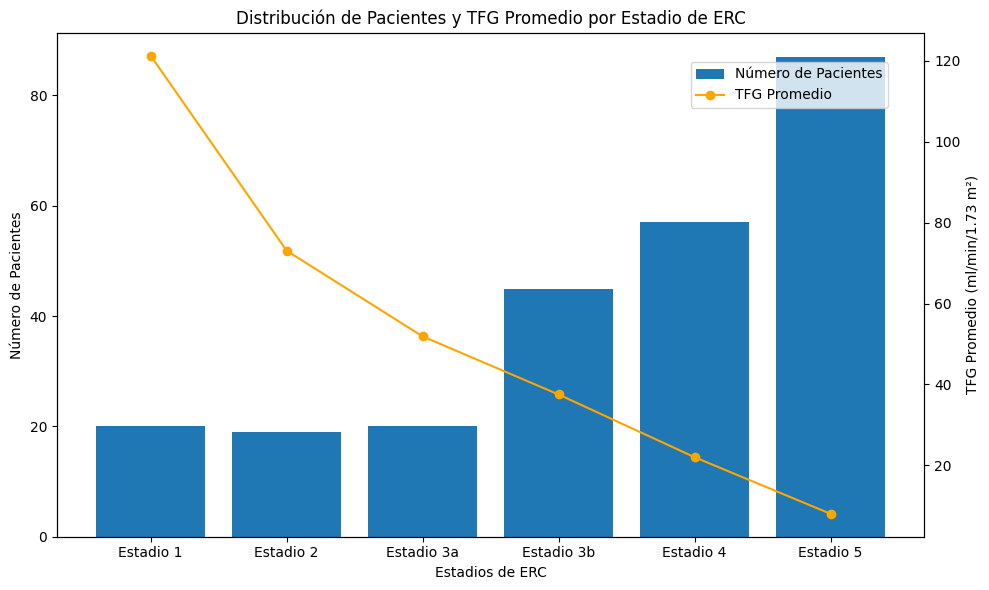

In [44]:
import matplotlib.pyplot as plt

# Calcular la cantidad de pacientes y la TFG promedio por estadio
estadios_resumen = data.groupby('Estadio_ERC').agg(
    Pacientes=('Estadio_ERC', 'count'),
    TFG_Promedio=('TFG', 'mean')
).sort_index()

# Crear el gráfico de barras
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico de número de pacientes
ax1.bar(estadios_resumen.index, estadios_resumen['Pacientes'], color='#1f77b4', label='Número de Pacientes')
ax1.set_xlabel('Estadios de ERC')
ax1.set_ylabel('Número de Pacientes')
ax1.tick_params(axis='y')
ax1.set_title('Distribución de Pacientes y TFG Promedio por Estadio de ERC')

# Gráfico de TFG promedio (línea)
ax2 = ax1.twinx()
ax2.plot(estadios_resumen.index, estadios_resumen['TFG_Promedio'], color='orange', marker='o', label='TFG Promedio')
ax2.set_ylabel('TFG Promedio (ml/min/1.73 m²)')
ax2.tick_params(axis='y')

# Agregar leyendas
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

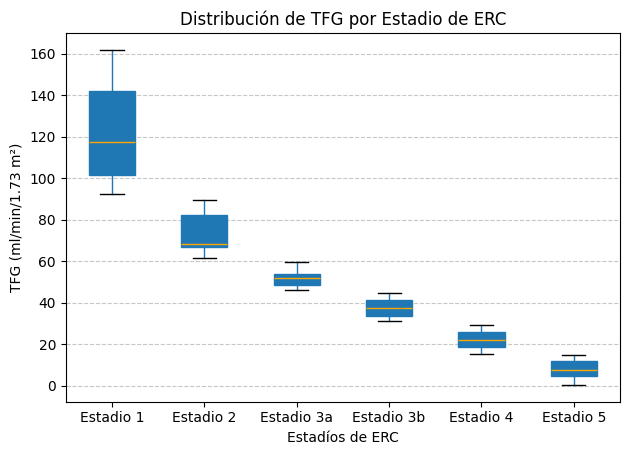

In [45]:
# Crear el boxplot
plt.figure(figsize=(10, 6))
data.boxplot(column='TFG', by='Estadio_ERC', grid=False, patch_artist=True,
             boxprops=dict(facecolor='#1f77b4', color='#1f77b4'), medianprops=dict(color='orange'))

plt.title('Distribución de TFG por Estadio de ERC')
plt.suptitle('')  # Eliminar el título por defecto del boxplot
plt.xlabel('Estadíos de ERC')
plt.ylabel('TFG (ml/min/1.73 m²)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


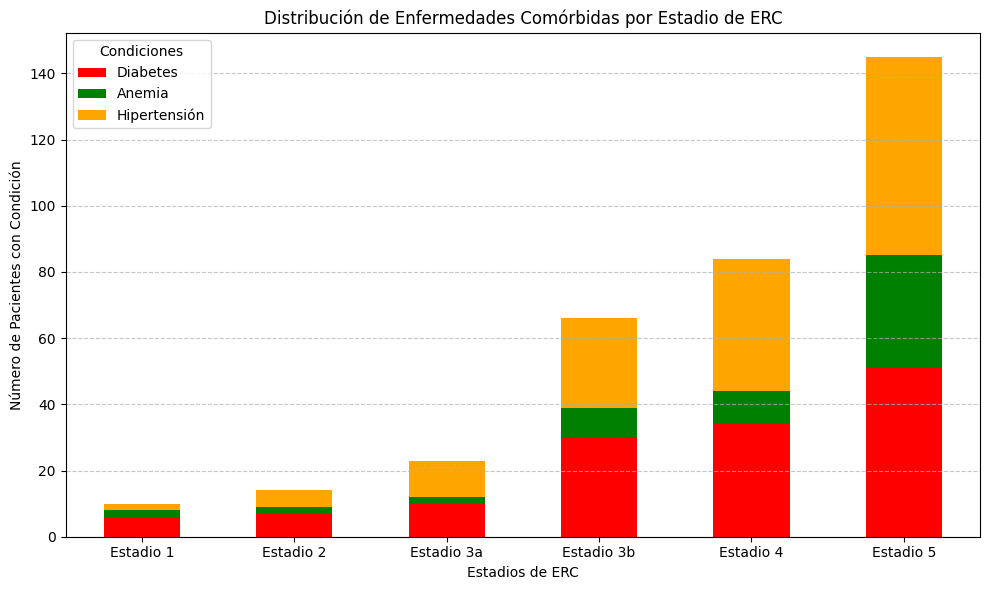

In [46]:
# Preparar datos para el gráfico apilado
estadios_condiciones = data.groupby('Estadio_ERC').agg(
    Diabetes=('Diabetes', 'sum'),
    Anemia=('Anemia', 'sum'),
    Hipertension=('Hipertension', 'sum')
).sort_index()

# Crear el gráfico apilado
estadios_condiciones.plot(kind='bar', stacked=True, figsize=(10, 6), color=['red', 'green', 'orange'])

# Personalizar el gráfico
plt.title('Distribución de Enfermedades Comórbidas por Estadio de ERC')
plt.xlabel('Estadios de ERC')
plt.ylabel('Número de Pacientes con Condición')
plt.xticks(rotation=0)
plt.legend(title='Condiciones', labels=['Diabetes', 'Anemia', 'Hipertensión'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


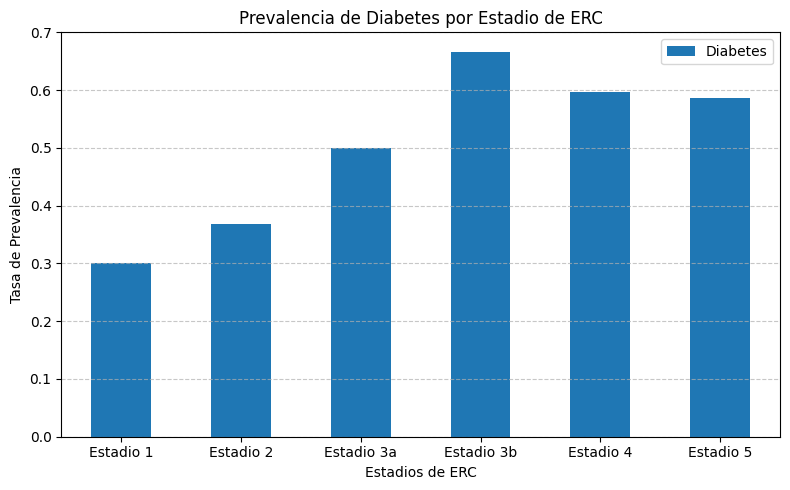

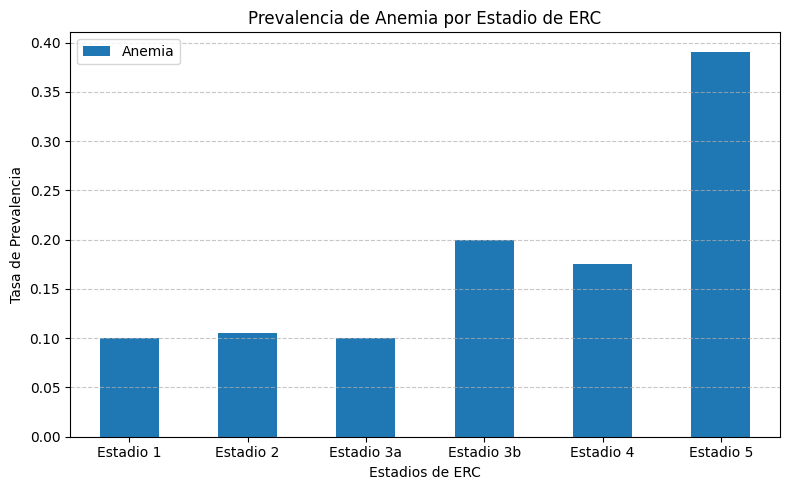

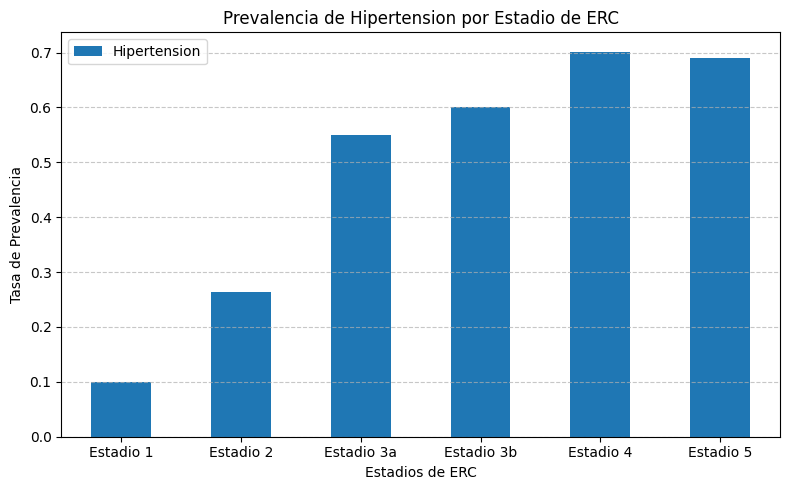

In [47]:
import matplotlib.pyplot as plt

# Lista de condiciones a graficar
condiciones = ['Diabetes', 'Anemia', 'Hipertension']

# Crear un gráfico separado para cada condición
for condicion in condiciones:
    data.groupby('Estadio_ERC')[condicion].mean().plot(
        kind='bar', figsize=(8, 5), color='#1f77b4', legend=True
    )
    plt.title(f'Prevalencia de {condicion} por Estadio de ERC')
    plt.xlabel('Estadios de ERC')
    plt.ylabel('Tasa de Prevalencia')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


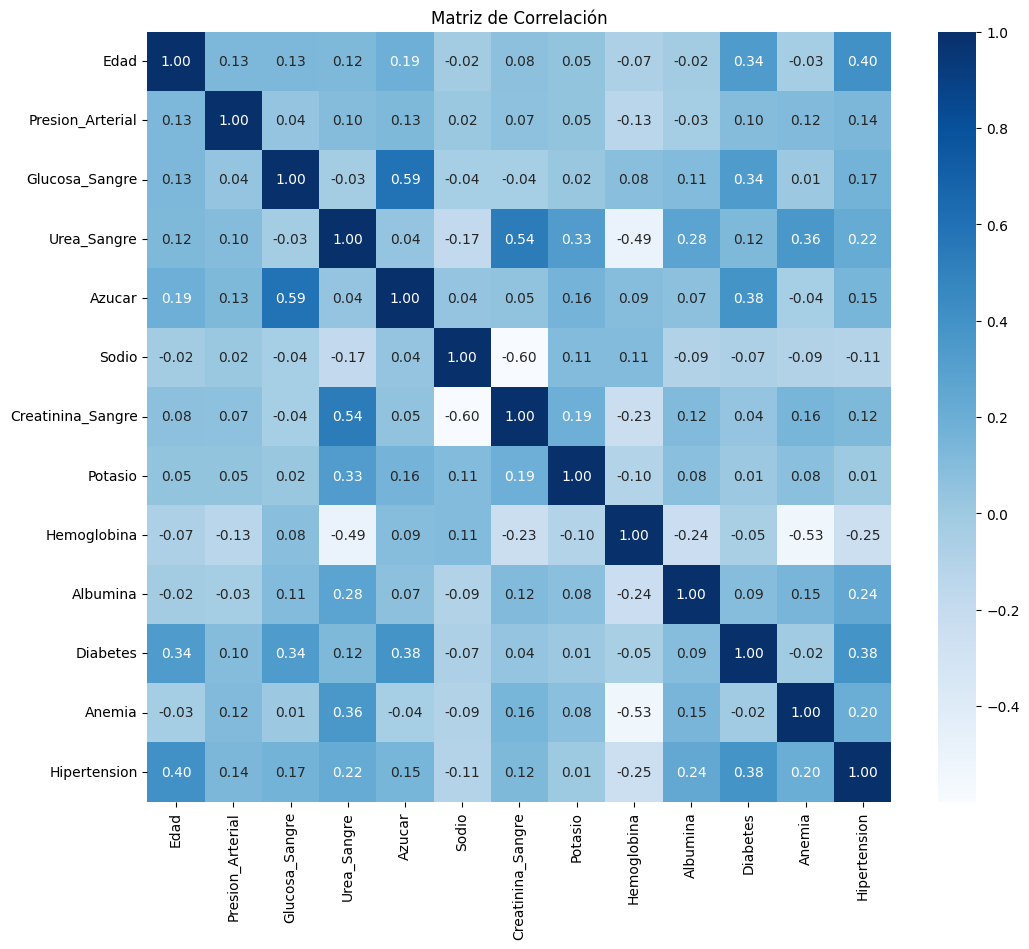

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
variables2 = ['Edad', 'Presion_Arterial', 'Glucosa_Sangre', 'Urea_Sangre','Azucar', 'Sodio',
             'Creatinina_Sangre', 'Potasio', 'Hemoglobina', 'Albumina', 'Diabetes', 'Anemia', 'Hipertension']

correlation_matrix = data[variables2].corr()


# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=True)


plt.title('Matriz de Correlación')
plt.show()

In [49]:
# Normalización de datos
scaler = StandardScaler()
data[variables] = scaler.fit_transform(data[variables])

# División de datos en entrenamiento y prueba
X = data[variables]
y = data['Diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Balanceo de datos con SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

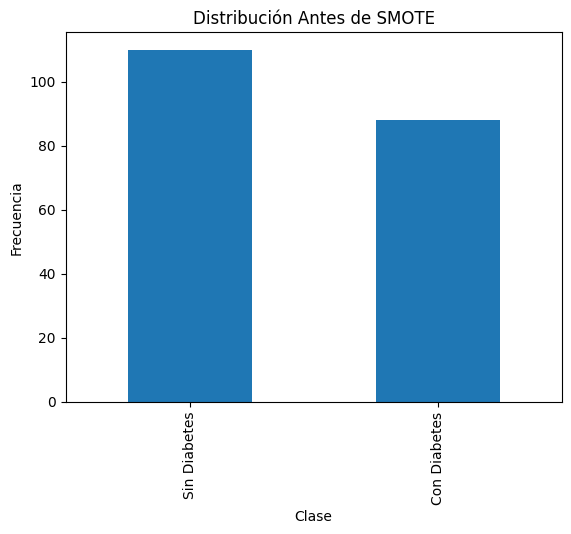

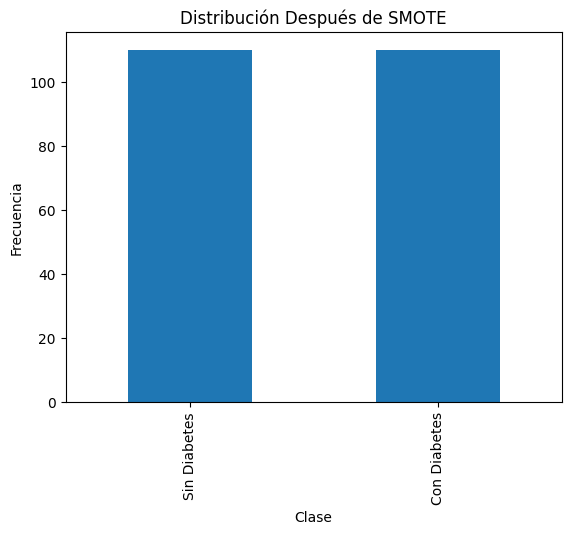

In [50]:
# Diccionario de nombres de clases
clases = {0: 'Sin Diabetes', 1: 'Con Diabetes'}

# Distribución de clases antes del balanceo
y_train.value_counts().plot(kind='bar', color='#1f77b4', title='Distribución Antes de SMOTE')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(ticks=[0, 1], labels=[clases[0], clases[1]])  # Etiquetas descriptivas
plt.show()

# Distribución de clases después del balanceo
y_train_balanced.value_counts().plot(kind='bar', color='#1f77b4', title='Distribución Después de SMOTE')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(ticks=[0, 1], labels=[clases[0], clases[1]])  # Etiquetas descriptivas
plt.show()

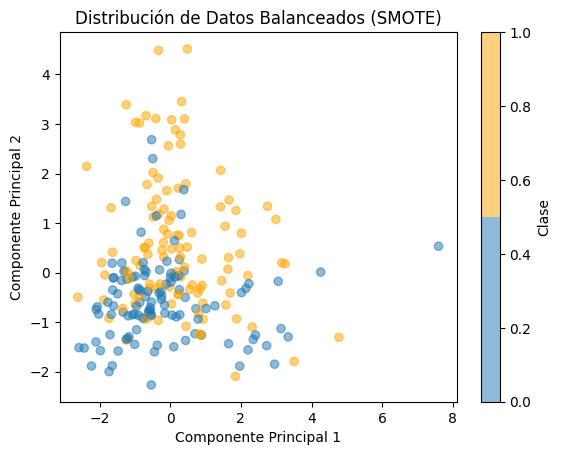

In [51]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# Reducción de dimensionalidad a 2 componentes principales
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_balanced)

# Graficar los datos balanceados
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_balanced, cmap=ListedColormap(["#1f77b4", "orange"]), alpha=0.5)


plt.title('Distribución de Datos Balanceados (SMOTE)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Clase')
plt.show()


In [52]:
X.describe()

,Edad,Presion_Arterial,Glucosa_Sangre,Urea_Sangre,Azucar,Sodio,Creatinina_Sangre,Potasio,Hemoglobina,Albumina
count,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02,2.480000e+02
mean,1.683241e-16,1.647428e-16,7.520866e-17,-2.148819e-17,7.162729e-18,-2.256260e-16,-7.162729e-17,1.217664e-16,1.504173e-16,-2.542769e-16
std,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00,1.002022e+00
min,-3.067123e+00,-1.993305e+00,-1.808412e+00,-1.247448e+00,-6.291101e-01,-1.272853e+01,-5.787384e-01,-6.740431e-01,-3.820726e+00,-1.369299e+00
25%,-3.905206e-01,-6.512777e-01,-7.629941e-01,-7.127487e-01,-6.291101e-01,0.000000e+00,-4.315037e-01,-2.214811e-01,-4.311432e-01,-5.737288e-01
50%,2.384077e-01,1.973569e-02,-1.239637e-01,-3.095327e-01,-6.291101e-01,0.000000e+00,-2.916308e-01,2.512224e-16,-8.986730e-16,-1.766522e-16
75%,6.186900e-01,6.907491e-01,4.149420e-01,3.040570e-01,0.000000e+00,3.066938e-01,0.000000e+00,2.512224e-16,5.806726e-01,1.017412e+00
max,2.081314e+00,6.729870e+00,3.704328e+00,5.580928e+00,3.452142e+00,2.864550e+00,1.053748e+01,1.191284e+01,2.756077e+00,2.608553e+00


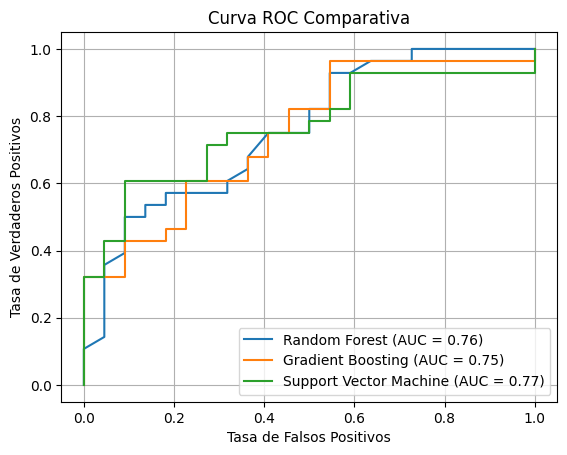

In [53]:

# Paso 4: Comparar tres modelos
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42)
}

results = {}
for model_name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_prob)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[model_name] = {
        'AUC': auc,
        'Classification Report': report
    }

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

plt.title('Curva ROC Comparativa')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend()
plt.grid()
plt.show()


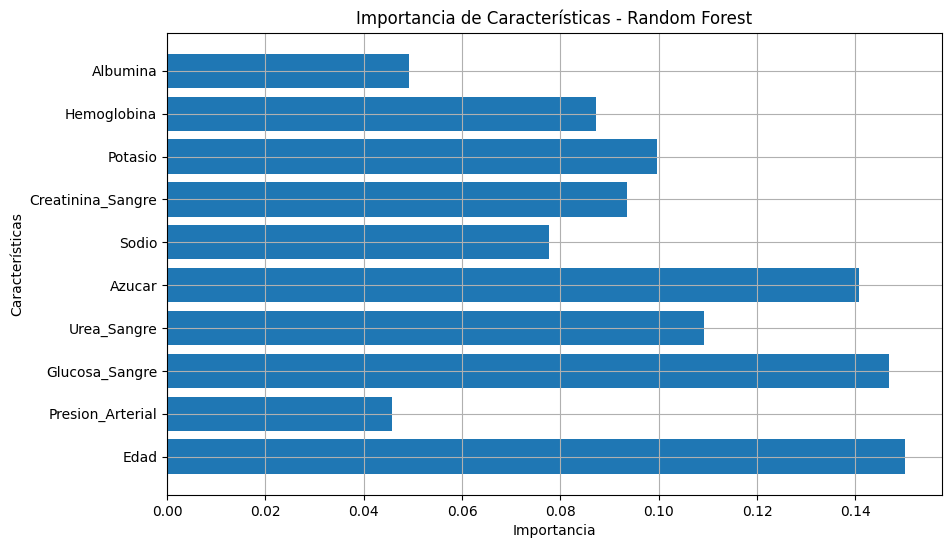

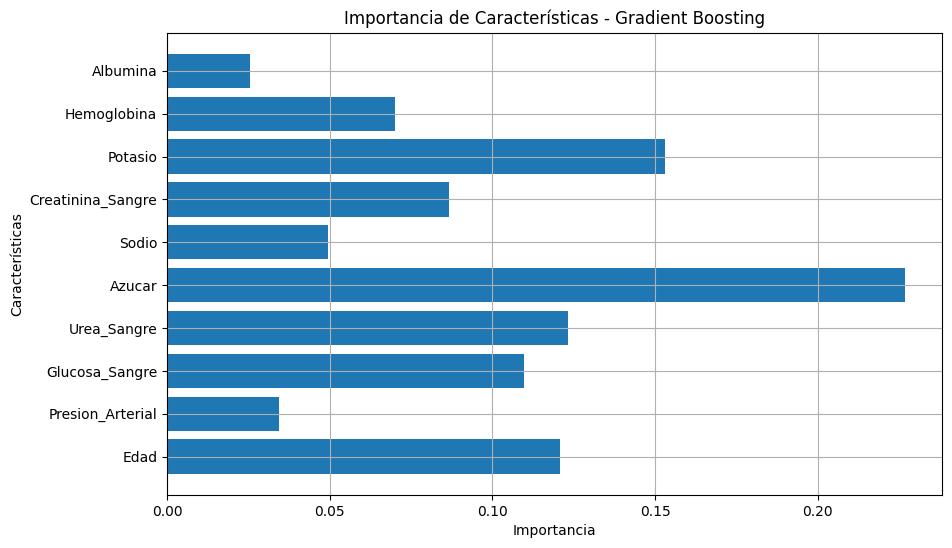

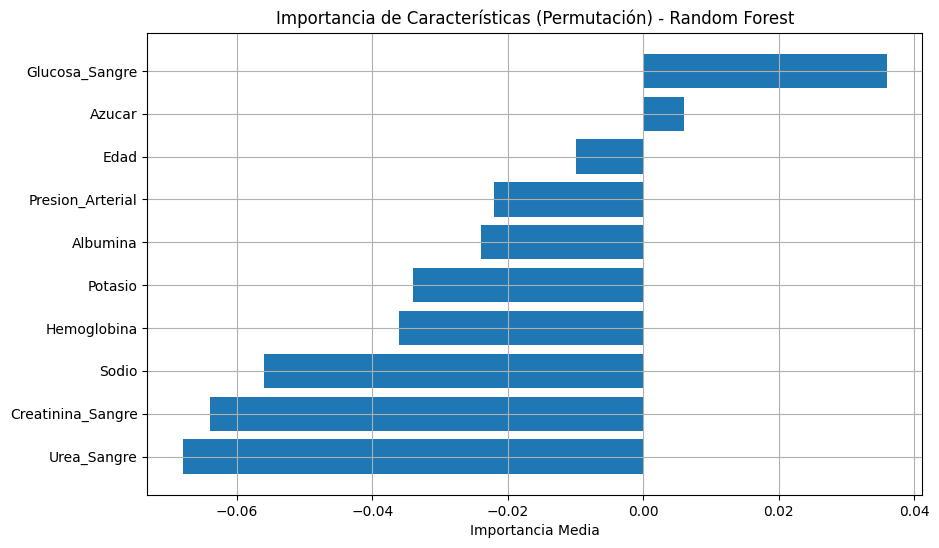

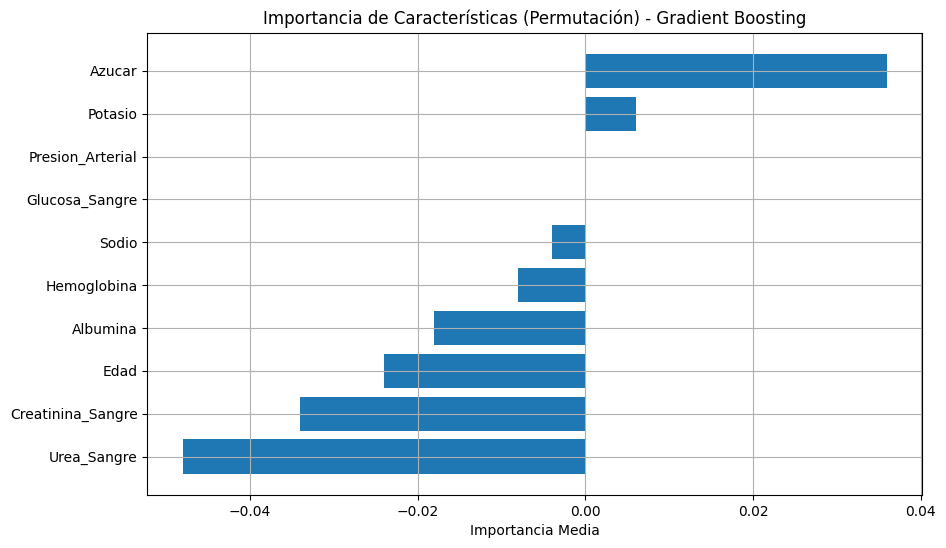

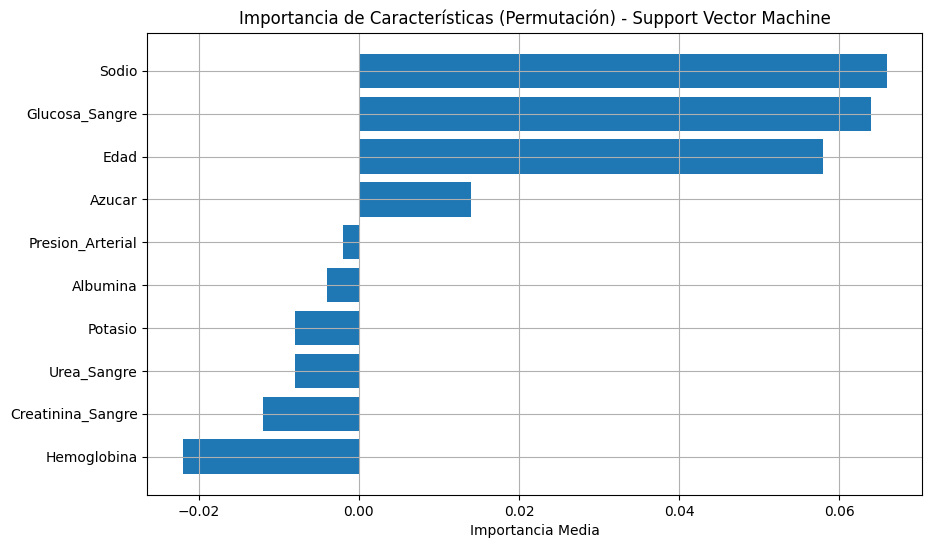


Resultados Comparativos:
                             AUC  F1-Score
Random Forest           0.759740  0.620760
Gradient Boosting       0.750000  0.621373
Support Vector Machine  0.766234  0.701084


In [54]:

# Paso 5: Visualización de importancia de características (solo para Random Forest y Gradient Boosting)
for model_name in ['Random Forest', 'Gradient Boosting']:
    model = models[model_name]
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, 6))
        plt.barh(variables, model.feature_importances_)
        plt.title(f'Importancia de Características - {model_name}')
        plt.xlabel('Importancia')
        plt.ylabel('Características')
        plt.grid()
        plt.show()

# Paso 5: Alternativa a SHAP con Permutación de Importancias
from sklearn.inspection import permutation_importance

for model_name, model in models.items():
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    sorted_idx = perm_importance.importances_mean.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(np.array(variables)[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.title(f'Importancia de Características (Permutación) - {model_name}')
    plt.xlabel('Importancia Media')
    plt.grid()
    plt.show()

# Paso 6: Mostrar resultados en tabla
resultados_df = pd.DataFrame({
    model_name: [results[model_name]['AUC'], results[model_name]['Classification Report']['weighted avg']['f1-score']]
    for model_name in results
}, index=['AUC', 'F1-Score']).T

print("\nResultados Comparativos:")
print(resultados_df)

Ejemplos de predicción para desarrollo de diabetes en pacientes con ERC:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python

{'Paciente': 225, 'Random Forest': {'Riesgo': 'Alto', 'Probabilidad': '0.85'}, 'Gradient Boosting': {'Riesgo': 'Alto', 'Probabilidad': '0.92'}, 'Support Vector Machine': {'Riesgo': 'Alto', 'Probabilidad': '0.73'}}
{'Paciente': 119, 'Random Forest': {'Riesgo': 'Bajo', 'Probabilidad': '0.18'}, 'Gradient Boosting': {'Riesgo': 'Bajo', 'Probabilidad': '0.11'}, 'Support Vector Machine': {'Riesgo': 'Bajo', 'Probabilidad': '0.33'}}
{'Paciente': 133, 'Random Forest': {'Riesgo': 'Medio', 'Probabilidad': '0.58'}, 'Gradient Boosting': {'Riesgo': 'Medio', 'Probabilidad': '0.53'}, 'Support Vector Machine': {'Riesgo': 'Medio', 'Probabilidad': '0.36'}}
{'Paciente': 228, 'Random Forest': {'Riesgo': 'Alto', 'Probabilidad': '0.92'}, 'Gradient Boosting': {'Riesgo': 'Alto', 'Probabilidad': '0.93'}, 'Support Vector Machine': {'Riesgo': 'Medio', 'Probabilidad': '0.59'}}
{'Paciente': 60, 'Random Forest': {'Riesgo': 'Medio', 'Probabilidad': '0.51'}, 'Gradient Boosting': {'Riesgo': 'Medio', 'Probabilidad': '0.4

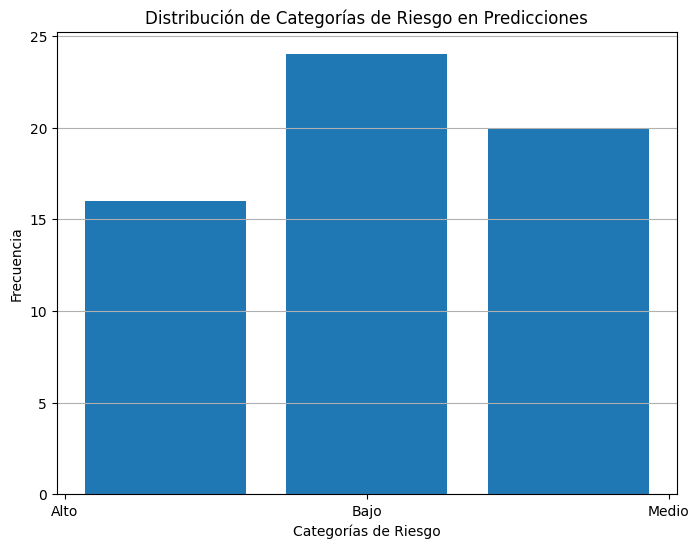

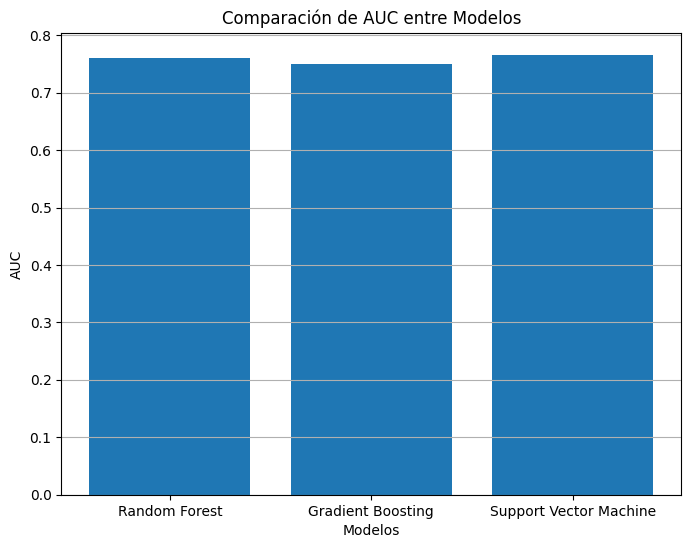

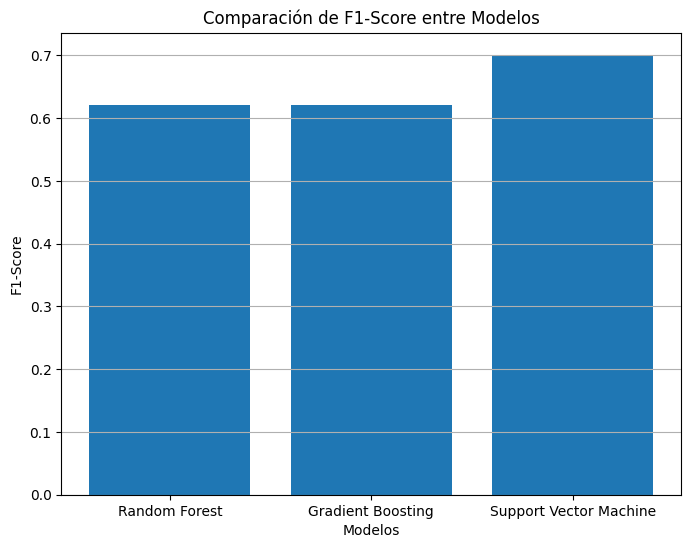

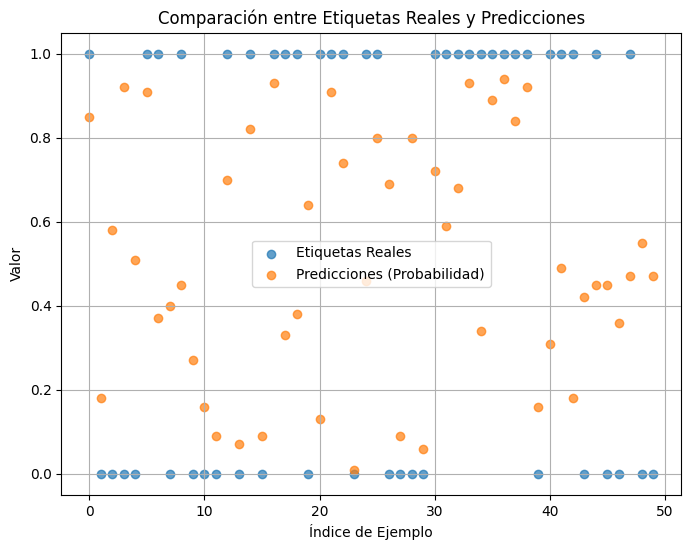

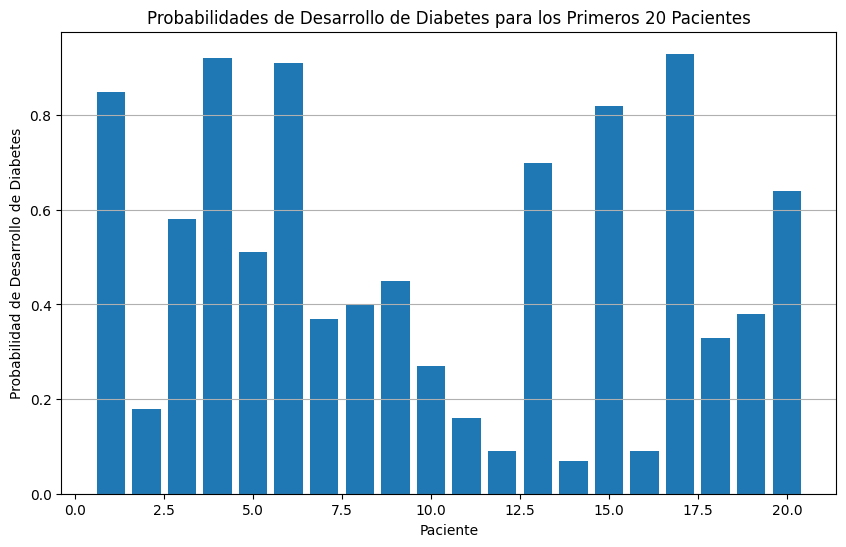

In [55]:
# EJEMPLOS DE PREDICCIÓN EN PACIENTES CON ERC
examples = X_test.iloc[:20]  # PRIMEROS 20 EJEMPLOS DE TEST
print("Ejemplos de predicción para desarrollo de diabetes en pacientes con ERC:")
example_results = []
for i, example in examples.iterrows():
    example_result = {"Paciente": i}
    for model_name, model in models.items():
        prob = model.predict_proba([example])[0][1]
        pred = "Alto" if prob > 0.66 else "Medio" if prob >= 0.33 else "Bajo"
        example_result[model_name] = {
            "Riesgo": pred,
            "Probabilidad": f"{prob:.2f}"
        }
    example_results.append(example_result)

for result in example_results:
    print(result)

# RESULTADOS COMPARATIVOS
resultados_df = pd.DataFrame({
    model_name: [results[model_name]['AUC'], results[model_name]['Classification Report']['weighted avg']['f1-score']]
    for model_name in results
}, index=['AUC', 'F1-Score']).T

print("\nResultados Comparativos para Desarrollo de Diabetes en ERC:")
print(resultados_df)

# GRAFICOS ADICIONALES PARA RESALTAR RESULTADOS
# Distribución de las categorías de riesgo
riesgos = []
for example in example_results:
    for model_name in models.keys():
        riesgos.append(example[model_name]['Riesgo'])

plt.figure(figsize=(8, 6))
plt.hist(riesgos, bins=3, align='mid', rwidth=0.8, color='#1f77b4')
plt.title('Distribución de Categorías de Riesgo en Predicciones')
plt.xlabel('Categorías de Riesgo')
plt.ylabel('Frecuencia')
plt.grid(axis='y')
plt.show()

# Comparación de AUC entre modelos
auc_values = [results[model]['AUC'] for model in models.keys()]
plt.figure(figsize=(8, 6))
plt.bar(models.keys(), auc_values, color='#1f77b4')
plt.title('Comparación de AUC entre Modelos')
plt.xlabel('Modelos')
plt.ylabel('AUC')
plt.grid(axis='y')
plt.show()

# Comparación de F1-Score entre modelos
f1_scores = [results[model]['Classification Report']['weighted avg']['f1-score'] for model in models.keys()]
plt.figure(figsize=(8, 6))
plt.bar(models.keys(), f1_scores, color='#1f77b4')
plt.title('Comparación de F1-Score entre Modelos')
plt.xlabel('Modelos')
plt.ylabel('F1-Score')
plt.grid(axis='y')
plt.show()

# GRAFICO DE COMPARACIÓN ENTRE PREDICCIONES Y ETIQUETAS REALES
y_test_array = y_test.values
predicted_probs = models['Random Forest'].predict_proba(X_test)[:, 1]  # USANDO RANDOM FOREST COMO EJEMPLO
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test_array)), y_test_array, label='Etiquetas Reales', alpha=0.7)
plt.scatter(range(len(predicted_probs)), predicted_probs, label='Predicciones (Probabilidad)', alpha=0.7)
plt.title('Comparación entre Etiquetas Reales y Predicciones')
plt.xlabel('Índice de Ejemplo')
plt.ylabel('Valor')
plt.legend()
plt.grid()
plt.show()

# GRAFICO PARA LAS 20 PERSONAS EJEMPLARES
pacientes = list(range(1, 21))
riesgos_random_forest = [float(example['Random Forest']['Probabilidad']) for example in example_results]
plt.figure(figsize=(10, 6))
plt.bar(pacientes, riesgos_random_forest, color='#1f77b4')
plt.title('Probabilidades de Desarrollo de Diabetes para los Primeros 20 Pacientes')
plt.xlabel('Paciente')
plt.ylabel('Probabilidad de Desarrollo de Diabetes')
plt.grid(axis='y')
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python

    Paciente Estadio_ERC     Diabetes       Anemia Hipertension
0        225   Estadio 4  Riesgo Alto   Sin Riesgo  Riesgo Alto
1        119   Estadio 2   Sin Riesgo   Sin Riesgo   Sin Riesgo
2        133   Estadio 5   Sin Riesgo   Sin Riesgo  Riesgo Alto
3        228   Estadio 4   Sin Riesgo   Sin Riesgo  Riesgo Alto
4         60   Estadio 5   Sin Riesgo   Sin Riesgo  Riesgo Alto
5         70   Estadio 1  Riesgo Alto   Sin Riesgo  Riesgo Alto
6        157  Estadio 3b  Riesgo Alto   Sin Riesgo  Riesgo Alto
7         36   Estadio 4   Sin Riesgo   Sin Riesgo  Riesgo Alto
8        159  Estadio 3a  Riesgo Alto   Sin Riesgo   Sin Riesgo
9        247   Estadio 2   Sin Riesgo  Riesgo Alto   Sin Riesgo
10       163  Estadio 3b   Sin Riesgo  Riesgo Alto  Riesgo Alto
11       209   Estadio 5   Sin Riesgo   Sin Riesgo   Sin Riesgo
12       106   Estadio 5  Riesgo Alto  Riesgo Alto  Riesgo Alto
13         4  Estadio 3b   Sin Riesgo   Sin Riesgo   Sin Riesgo
14       249   Estadio 5  Riesgo Alto  R

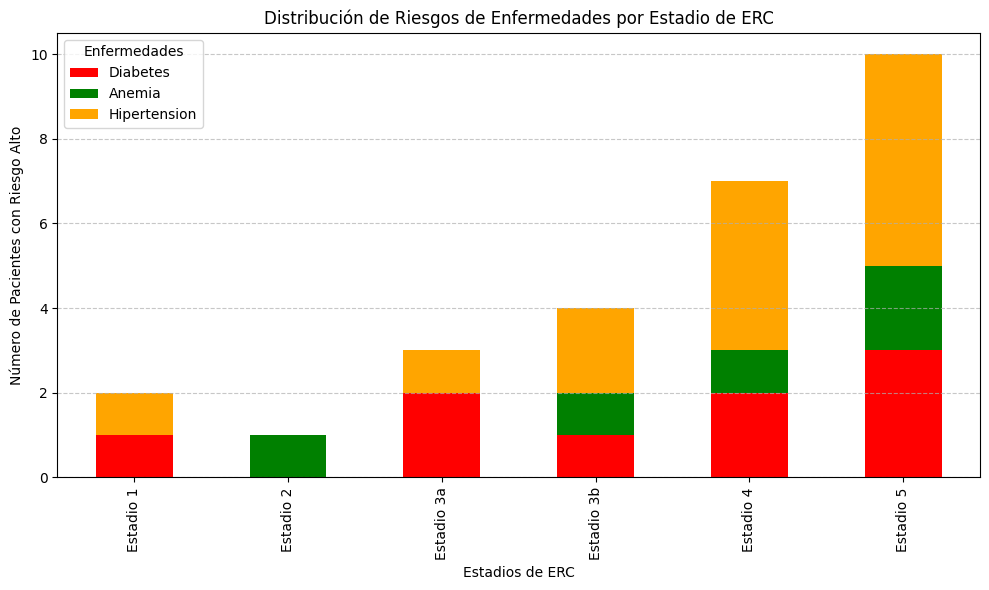

In [56]:
# Agregar los estadios de ERC y las condiciones a los ejemplos seleccionados
examples = X_test.iloc[:20].copy()
examples['Estadio_ERC'] = data.loc[examples.index, 'Estadio_ERC']
examples['Diabetes'] = data.loc[examples.index, 'Diabetes']
examples['Anemia'] = data.loc[examples.index, 'Anemia']
examples['Hipertension'] = data.loc[examples.index, 'Hipertension']

# Generar predicciones y asociarlas con los estadios y condiciones
example_results = []
for i, example in examples.iterrows():
    example_result = {
        "Paciente": i,
        "Estadio_ERC": example['Estadio_ERC'],
        "Diabetes": "Riesgo Alto" if example['Diabetes'] == 1 else "Sin Riesgo",
        "Anemia": "Riesgo Alto" if example['Anemia'] == 1 else "Sin Riesgo",
        "Hipertension": "Riesgo Alto" if example['Hipertension'] == 1 else "Sin Riesgo"
    }
    for model_name, model in models.items():
        prob = model.predict_proba([example.drop(['Estadio_ERC', 'Diabetes', 'Anemia', 'Hipertension'])])[0][1]
        pred = "Alto" if prob > 0.66 else "Medio" if prob >= 0.33 else "Bajo"
        example_result[model_name] = {
            "Riesgo": pred,
            "Probabilidad": f"{prob:.2f}"
        }
    example_results.append(example_result)

# Convertir los resultados a un DataFrame para visualización
example_results_df = pd.DataFrame(example_results)

# Mostrar tabla resumida de resultados
print(example_results_df[['Paciente', 'Estadio_ERC', 'Diabetes', 'Anemia', 'Hipertension']])

# Gráfico de categorías de riesgo por estadio para cada enfermedad
riesgos_por_estadio = example_results_df.groupby('Estadio_ERC').apply(
    lambda x: pd.DataFrame({
        "Diabetes": (x['Diabetes'] == "Riesgo Alto").sum(),
        "Anemia": (x['Anemia'] == "Riesgo Alto").sum(),
        "Hipertension": (x['Hipertension'] == "Riesgo Alto").sum()
    }, index=[0])
).reset_index(level=1, drop=True)

# Crear gráfico apilado por enfermedad
riesgos_por_estadio.plot(kind='bar', stacked=True, figsize=(10, 6), color=['red', 'green', 'orange'])

# Personalizar el gráfico
plt.title('Distribución de Riesgos de Enfermedades por Estadio de ERC')
plt.xlabel('Estadios de ERC')
plt.ylabel('Número de Pacientes con Riesgo Alto')
plt.legend(title='Enfermedades')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python

    Paciente Estadio_ERC     Diabetes       Anemia Hipertension  \
0        225   Estadio 4  Riesgo Alto   Sin Riesgo  Riesgo Alto   
1        119   Estadio 2   Sin Riesgo   Sin Riesgo   Sin Riesgo   
2        133   Estadio 5   Sin Riesgo   Sin Riesgo  Riesgo Alto   
3        228   Estadio 4   Sin Riesgo   Sin Riesgo  Riesgo Alto   
4         60   Estadio 5   Sin Riesgo   Sin Riesgo  Riesgo Alto   
5         70   Estadio 1  Riesgo Alto   Sin Riesgo  Riesgo Alto   
6        157  Estadio 3b  Riesgo Alto   Sin Riesgo  Riesgo Alto   
7         36   Estadio 4   Sin Riesgo   Sin Riesgo  Riesgo Alto   
8        159  Estadio 3a  Riesgo Alto   Sin Riesgo   Sin Riesgo   
9        247   Estadio 2   Sin Riesgo  Riesgo Alto   Sin Riesgo   
10       163  Estadio 3b   Sin Riesgo  Riesgo Alto  Riesgo Alto   
11       209   Estadio 5   Sin Riesgo   Sin Riesgo   Sin Riesgo   
12       106   Estadio 5  Riesgo Alto  Riesgo Alto  Riesgo Alto   
13         4  Estadio 3b   Sin Riesgo   Sin Riesgo   Sin Riesg

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skle

,Paciente,Estadio_ERC,Diabetes,Anemia,Hipertension,Random Forest_Riesgo,Random Forest_Probabilidad,Gradient Boosting_Riesgo,Gradient Boosting_Probabilidad,Support Vector Machine_Riesgo,Support Vector Machine_Probabilidad
0,225,Estadio 4,Riesgo Alto,Sin Riesgo,Riesgo Alto,Alto,0.85,Alto,0.92,Alto,0.73
1,119,Estadio 2,Sin Riesgo,Sin Riesgo,Sin Riesgo,Bajo,0.18,Bajo,0.11,Bajo,0.33
2,133,Estadio 5,Sin Riesgo,Sin Riesgo,Riesgo Alto,Medio,0.58,Medio,0.53,Medio,0.36
3,228,Estadio 4,Sin Riesgo,Sin Riesgo,Riesgo Alto,Alto,0.92,Alto,0.93,Medio,0.59
4,60,Estadio 5,Sin Riesgo,Sin Riesgo,Riesgo Alto,Medio,0.51,Medio,0.43,Medio,0.49
5,70,Estadio 1,Riesgo Alto,Sin Riesgo,Riesgo Alto,Alto,0.91,Alto,0.99,Alto,0.79
6,157,Estadio 3b,Riesgo Alto,Sin Riesgo,Riesgo Alto,Medio,0.37,Bajo,0.11,Bajo,0.27
7,36,Estadio 4,Sin Riesgo,Sin Riesgo,Riesgo Alto,Medio,0.40,Bajo,0.19,Medio,0.54
8,159,Estadio 3a,Riesgo Alto,Sin Riesgo,Sin Riesgo,Medio,0.45,Bajo,0.13,Medio,0.62
9,247,Estadio 2,Sin Riesgo,Riesgo Alto,Sin Riesgo,Bajo,0.27,Bajo,0.11,Bajo,0.18


<ipython-input-57-90af861ee223>:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  riesgos_por_estadio = example_results_df.groupby('Estadio_ERC').apply(


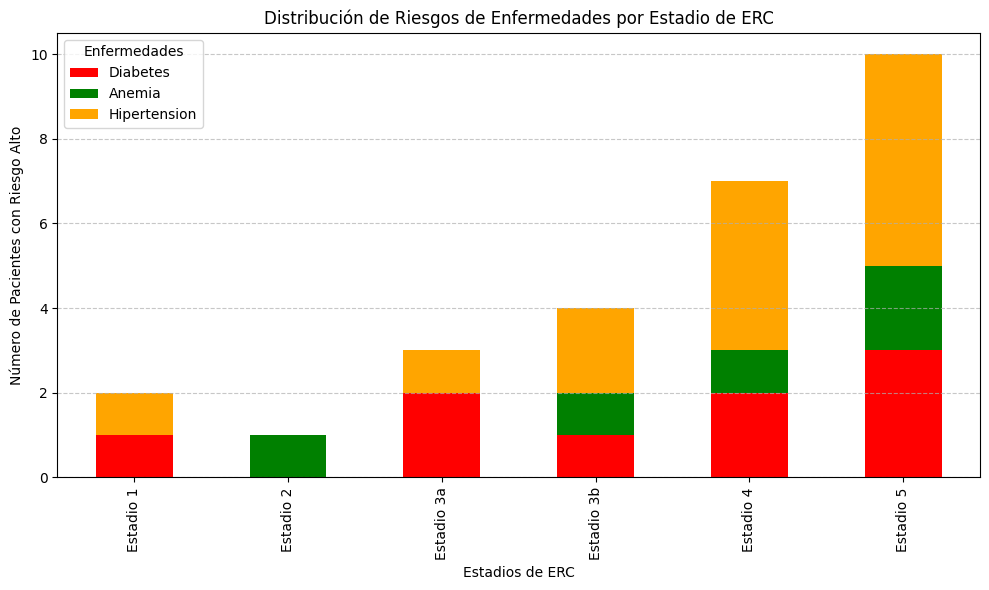

In [57]:
# Agregar los estadios de ERC y las condiciones a los ejemplos seleccionados
examples = X_test.iloc[:20].copy()
examples['Estadio_ERC'] = data.loc[examples.index, 'Estadio_ERC']
examples['Diabetes'] = data.loc[examples.index, 'Diabetes']
examples['Anemia'] = data.loc[examples.index, 'Anemia']
examples['Hipertension'] = data.loc[examples.index, 'Hipertension']

# Generar predicciones y asociarlas con los estadios y condiciones
example_results = []
for i, example in examples.iterrows():
    example_result = {
        "Paciente": i,
        "Estadio_ERC": example['Estadio_ERC'],
        "Diabetes": "Riesgo Alto" if example['Diabetes'] == 1 else "Sin Riesgo",
        "Anemia": "Riesgo Alto" if example['Anemia'] == 1 else "Sin Riesgo",
        "Hipertension": "Riesgo Alto" if example['Hipertension'] == 1 else "Sin Riesgo"
    }
    for model_name, model in models.items():
        prob = model.predict_proba([example.drop(['Estadio_ERC', 'Diabetes', 'Anemia', 'Hipertension'])])[0][1]
        pred = "Alto" if prob > 0.66 else "Medio" if prob >= 0.33 else "Bajo"
        example_result[f"{model_name}_Riesgo"] = pred
        example_result[f"{model_name}_Probabilidad"] = f"{prob:.2f}"
    example_results.append(example_result)

# Convertir los resultados a un DataFrame para visualización
example_results_df = pd.DataFrame(example_results)

# Mostrar tabla completa con probabilidades y riesgos
print(example_results_df)
example_results_df.head()
# Mostrar la tabla completa
from IPython.display import display
display(example_results_df)
# Gráfico de categorías de riesgo por estadio para cada enfermedad
riesgos_por_estadio = example_results_df.groupby('Estadio_ERC').apply(
    lambda x: pd.DataFrame({
        "Diabetes": (x['Diabetes'] == "Riesgo Alto").sum(),
        "Anemia": (x['Anemia'] == "Riesgo Alto").sum(),
        "Hipertension": (x['Hipertension'] == "Riesgo Alto").sum()
    }, index=[0])
).reset_index(level=1, drop=True)

# Crear gráfico apilado por enfermedad
riesgos_por_estadio.plot(kind='bar', stacked=True, figsize=(10, 6), color=['red', 'green', 'orange'])

# Personalizar el gráfico
plt.title('Distribución de Riesgos de Enfermedades por Estadio de ERC')
plt.xlabel('Estadios de ERC')
plt.ylabel('Número de Pacientes con Riesgo Alto')
plt.legend(title='Enfermedades')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
